In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import json
import logging
from marshaltools import ProgramList
from astropy.time import Time
import astropy.units as u
import os

from Observatory import Observatory
from utils import get_config, plot_visibility, prepare_snifs_schedule

In [2]:
# If you are running this notebook for the first time, you will be prompted to enter your username and
# the path to your downloads from slack. If you entered something incorrectly, you can correct this in .config
config = get_config()

username = config['username']
date = '2019-07-25'
obs = 'uh88'
tshift = {'ntt': -0.25, 'uh88': 0}  # In units of days
trange = [Time(Time(date).jd+tshift[obs],format='jd'), Time(Time(date).jd+1.+tshift[obs],format='jd')]

logpath = 'logs/'

# log
logger = logging.getLogger(username)
handler = logging.FileHandler(os.path.join(logpath, 'ztfcosmo_visibilty_%s_%s_%s.log'%(obs,date,username)))
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [3]:
observatories ={
    'uh88': Observatory('uh88', 19.8231, -155.47, 4205, sun_alt_th=-17, logger=logger),
    'ntt': Observatory('ntt', -29.25, -70.73, 2375, sun_alt_th=-12, logger=logger), # What's the twilight limit for ePESSTO?
}

INFO:ufeindt:Initialized Observatory uh88 at position (lon 19.82 deg, lat -155.47 deg, alt: 4205.0 m)
INFO:ufeindt:Initialized Observatory ntt at position (lon -29.25 deg, lat -70.73 deg, alt: 2375.0 m)


In [4]:
# Calculate dark time and observation windows
dark_time = observatories[obs].get_dark_times(trange)

INFO:ufeindt:computed dark times (sun_alt: -17.00) between 2019-07-25 00:00:00.000 and 2019-07-25 23:55:00.000. Total of 8.33 hours of dark


In [5]:
# Load one of the marshal programs to get the coordinates of your targets (pick one that has all/most of them)
pl = ProgramList('Redshift Completeness Factor')

INFO:marshaltools.ProgramList:Initialized ProgramList for program Redshift Completeness Factor (ID 2)
INFO:marshaltools.ProgramList:Loaded 2985 saved sources for program Redshift Completeness Factor.


In [14]:
# If you have a commented list of 

targets_raw = """High prio
ZTF19abgdcyx    -     Weird SEDM spec, weird lightcurve
ZTF19abfioty    - missing from marshal
ZTF19abctosq - I band lc and faint host
Unidentified sn like LC (in some very weak order of priority)
ZTF19abfpupe (would be good, bright and still not done by SEDM)
ZTF19abfaqqo (sn after peak, hostless, so would be good)
ZTF19abfwfei (would be good, bright and still not done by SEDM)
ZTF19abfdsbu
ZTF19abfwtkw
ZTF19abgbbpx
ZTF19abguzsx
Known SNIa at peak:
ZTF19abgcbey
ZTF19abgnuri
ZTF19abgprpq
ZTF19abglmpf
ZTF19abfhszx (possibly declining already)
Fillers:
ZTF19abfzhzc
ZTF19abgawrv
ZTF19abgkfed"""

In [15]:
# List your targets here
targets = [a.split(' ')[0] for a in targets_raw.split('\n') if a.startswith('ZTF1')]

In [21]:
# Check whether targets are in the loaded program
for snname in targets:
    if snname not in pl.sources.keys():
        print(snname)

In [20]:
# Load some more programs to make sure you have all the coordinates
for p_ in ['AMPEL Test', 
           #'AmpelTNS',
           #'Redshift Completeness Factor', 
           #'Infant Supernovae',
           'Superluminous Supernovae II'
          ]:
    pl_tmp = ProgramList(p_)
    for k, v in pl_tmp.sources.items():
        if k not in pl.sources.keys():
            pl.sources[k] = v

INFO:marshaltools.ProgramList:Initialized ProgramList for program AMPEL Test (ID 10)
INFO:marshaltools.ProgramList:Loaded 2437 saved sources for program AMPEL Test.
INFO:marshaltools.ProgramList:Initialized ProgramList for program Superluminous Supernovae II (ID 9)
INFO:marshaltools.ProgramList:Loaded 1127 saved sources for program Superluminous Supernovae II.


In [41]:
obs_windows = {}

In [42]:
observatories[obs].min_moon_dist = 30

In [43]:
for snname in targets:
    ra = pl.sources[snname]['ra']
    dec = pl.sources[snname]['dec']
    logger.info('Calculating visibility of source %s (ra: %f, dec: %f) with %s.'%(snname, ra, dec, obs))
    obs_w = observatories[obs].compute_visibility(ra, dec, trange)
    if len(obs_w['visible']) > 0:
        obs_windows[snname] = obs_w
    else:
        logger.info('Source %s (ra: %f, dec: %f) not observable with %s.'%(snname, ra, dec, obs))

INFO:ufeindt:Calculating visibility of source ZTF19abgdcyx (ra: 250.761373, dec: 58.751249) with uh88.
INFO:ufeindt:computing visibility of source at (ra: 250.761373, dec: 58.751249) from observatory uh88
INFO:ufeindt:using visibility constraints:
					-Time resolution: 5.00 min
					-Airmass limit: 2.00
					-Sun altitude: -17.00 deg
					-Moon distance: 30.00 deg
INFO:ufeindt:computed dark times (sun_alt: -17.00) between 2019-07-25 00:00:00.000 and 2019-07-25 23:55:00.000. Total of 8.33 hours of dark
INFO:ufeindt:source is visible for a total of 5.167 hours. Took 1.38e+00 sec
INFO:ufeindt:Calculating visibility of source ZTF19abfioty (ra: 35.270327, dec: 23.603841) with uh88.
INFO:ufeindt:computing visibility of source at (ra: 35.270327, dec: 23.603841) from observatory uh88
INFO:ufeindt:using visibility constraints:
					-Time resolution: 5.00 min
					-Airmass limit: 2.00
					-Sun altitude: -17.00 deg
					-Moon distance: 30.00 deg
INFO:ufeindt:computed dark times (sun_alt: -17.00

INFO:ufeindt:source is visible for a total of 8.000 hours. Took 1.00e+00 sec
INFO:ufeindt:Calculating visibility of source ZTF19abfhszx (ra: 316.213949, dec: -22.041078) with uh88.
INFO:ufeindt:computing visibility of source at (ra: 316.213949, dec: -22.041078) from observatory uh88
INFO:ufeindt:using visibility constraints:
					-Time resolution: 5.00 min
					-Airmass limit: 2.00
					-Sun altitude: -17.00 deg
					-Moon distance: 30.00 deg
INFO:ufeindt:computed dark times (sun_alt: -17.00) between 2019-07-25 00:00:00.000 and 2019-07-25 23:55:00.000. Total of 8.33 hours of dark
INFO:ufeindt:source is visible for a total of 6.250 hours. Took 1.02e+00 sec
INFO:ufeindt:Calculating visibility of source ZTF19abfzhzc (ra: 26.616914, dec: 22.297318) with uh88.
INFO:ufeindt:computing visibility of source at (ra: 26.616914, dec: 22.297318) from observatory uh88
INFO:ufeindt:using visibility constraints:
					-Time resolution: 5.00 min
					-Airmass limit: 2.00
					-Sun altitude: -17.00 deg
	

In [44]:
print('%i of %i targets are observable with %s.'%(len(obs_windows.keys()), len(targets), obs))

15 of 18 targets are observable with uh88.


In [45]:
print([n_ for n_ in targets if n_ not in obs_windows.keys()])

['ZTF19abfioty', 'ZTF19abfzhzc', 'ZTF19abgawrv']


In [46]:
# Sort the SNe by time of lowest airmass etc
snnames = [k for k in obs_windows.keys()]

# Sort by end of visibility
f_sort = lambda a: np.where(dark_time == obs_windows[a]['visible'][-1])[0][0]
snnames = sorted(snnames, key=f_sort)
# Sort by start of visibility
f_sort = lambda a: np.where(dark_time == obs_windows[a]['visible'][0])[0][0]
snnames = sorted(snnames, key=f_sort)
# Sort by time of best airmass
f_sort = lambda a: np.where(dark_time == obs_windows[a]['visible'][obs_windows[a]['airmass'] == min(obs_windows[a]['airmass'])])[0][0]
snnames = sorted(snnames, key=f_sort)

# Priorities need to be assigned (semi)-manually using a dictionary of the target names 
# (easy if they are sorted by prio already) 
sort_dict = {}
for k, n_ in enumerate(targets):
    if n_ in targets[:3]:
        sort_dict[n_] = 0
    elif n_ in targets[:10]:
        sort_dict[n_] = 1
    elif n_ in targets[:15]:
        sort_dict[n_] = 2
    else:
        sort_dict[n_] = 3
    
f_sort = lambda a: sort_dict[a]
snnames = sorted(snnames, key=f_sort)
priorities = [f_sort(a) for a in snnames]

In [47]:
priorities

[0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3]

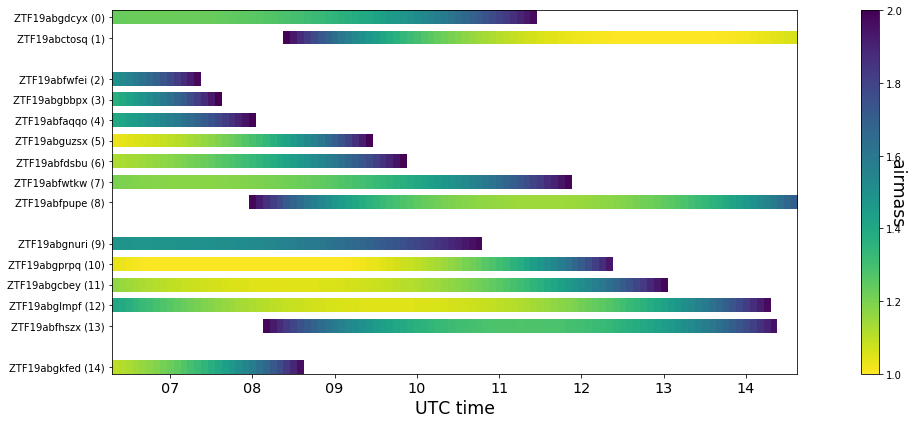

In [48]:
_ = plot_visibility(snnames, obs_windows, dark_time, priorities)

13 SNe selected


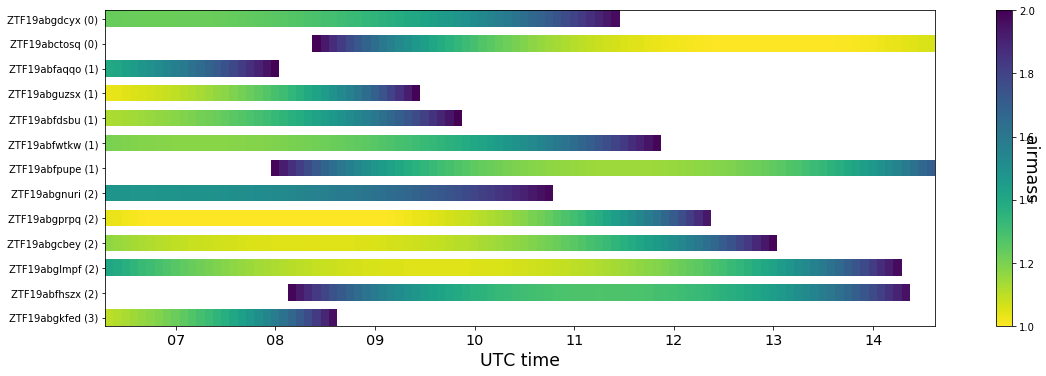

In [49]:
# Selected the targets by their indices
selected = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# Set manual priorities if you wish
prio_new = []
print('%i SNe selected'%len(selected))

snnames_selected = [snnames[k] for k in selected]
priorities_selected = [priorities[k] for k in selected]

sort_again = False
if sort_again:
    # sort them by time of lowest airmass again
    f_sort = lambda a: np.where(dark_time == obs_windows[a]['visible'][obs_windows[a]['airmass'] == min(obs_windows[a]['airmass'])])[0][0]
    if len(prio_new) < len(selected):
        tmp = sorted(zip(snnames_selected, priorities_selected) , key=lambda a: f_sort(a[0]))
    else:
        tmp = sorted(zip(snnames_selected, prio_new) , key=lambda a: f_sort(a[0]))
    snnames_selected = [a[0] for a in tmp]
    priorities_selected = [a[1] for a in tmp]

_ = plot_visibility(snnames_selected, obs_windows, dark_time, priorities_selected, labeltype='priority')
plt.savefig('snifs/targets_snifs_%s.png'%date)

In [50]:
if obs == 'uh88':
    if len(prio_new) == len(selected):
        snnames_out = [snnames[k] for k, p in sorted(zip(selected, prio_new), key=lambda a: a[1])]
    else:
        snnames_out = [snnames[k] for k in selected]
    prepare_snifs_schedule(snnames_out, pl.sources, obs_windows, date, logger=logger)